# **Non-Stationary Federated Learning**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Workers: **4**
*   Data Distribution: **IID on workers**





## Importing libraries and setting parameters for training


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt



np.random.seed(0)
torch.manual_seed(0)

In [54]:
num_workers = 4
num_rounds = 10

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [ ]:
iterations = 10

error_list = []
score_list = []

error_list_single = []
score_list_single = []

for iteration in range(0, iterations):
    
    # Linear Regression Coefficients
    m = 1.4
    c = 10

    dataset_X = np.linspace(0, 10, 500)
    np.random.shuffle(dataset_X)

    dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(20)

    dataset_X = dataset_X.reshape(-1,1)
    dataset_y = dataset_y.reshape(-1,1)
    
    train_percentage = 0.9


    train_X, test_X = np.split(dataset_X, 
                [int(train_percentage * len(dataset_X))
                ])

    train_y, test_y = np.split(dataset_y, 
                [int(train_percentage * len(dataset_y))
                ])
    
    train_list_X = splitDataset(train_X, num_workers, num_rounds)
    train_list_y = splitDataset(train_y, num_workers, num_rounds)
    
    worker_list = []
    for i in range(0, num_workers):
        worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))
        
        
    server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)
    
    
    from collections import defaultdict

    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)


    error = []
    score = []



    for i in range(0, num_rounds):

        for j in range(0, num_workers):

            worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
            pred_worker = worker_list[j].evaluate(test_X)

            # store loss info for current epoch 
            worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))

        server.aggregation() 
        server.return_to_workers()

        pred_server = server.evaluate(test_X)
        print('------ROUND {}------'.format(i+1))
        print('Mean squared error: %.3f' 
              % mean_squared_error(test_y, pred_server))
        print('Coefficient of determinaton: %.3f \n'
              % r2_score(test_y, pred_server))
        error.append(mean_squared_error(test_y, pred_server))
        score.append(r2_score(test_y, pred_server))
    
    error_list[iteration] = error
    score_list[iteration] = score
    

In [55]:
# Linear Regression Coefficients
m = 1.4
c = 10

dataset_X = np.linspace(0, 10, 500)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(20)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [56]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [57]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [58]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [59]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [60]:
from collections import defaultdict

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


error = []
score = []



for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
        pred_worker = worker_list[j].evaluate(test_X)
        
        # store loss info for current epoch 
        worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))
    
    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 18.131
Coefficient of determinaton: 0.513 

------ROUND 2------
Mean squared error: 17.591
Coefficient of determinaton: 0.527 

------ROUND 3------
Mean squared error: 18.033
Coefficient of determinaton: 0.515 

------ROUND 4------
Mean squared error: 17.817
Coefficient of determinaton: 0.521 

------ROUND 5------
Mean squared error: 17.603
Coefficient of determinaton: 0.527 

------ROUND 6------
Mean squared error: 17.635
Coefficient of determinaton: 0.526 

------ROUND 7------
Mean squared error: 17.764
Coefficient of determinaton: 0.523 

------ROUND 8------
Mean squared error: 17.543
Coefficient of determinaton: 0.528 

------ROUND 9------
Mean squared error: 17.420
Coefficient of determinaton: 0.532 

------ROUND 10------
Mean squared error: 17.389
Coefficient of determinaton: 0.533 



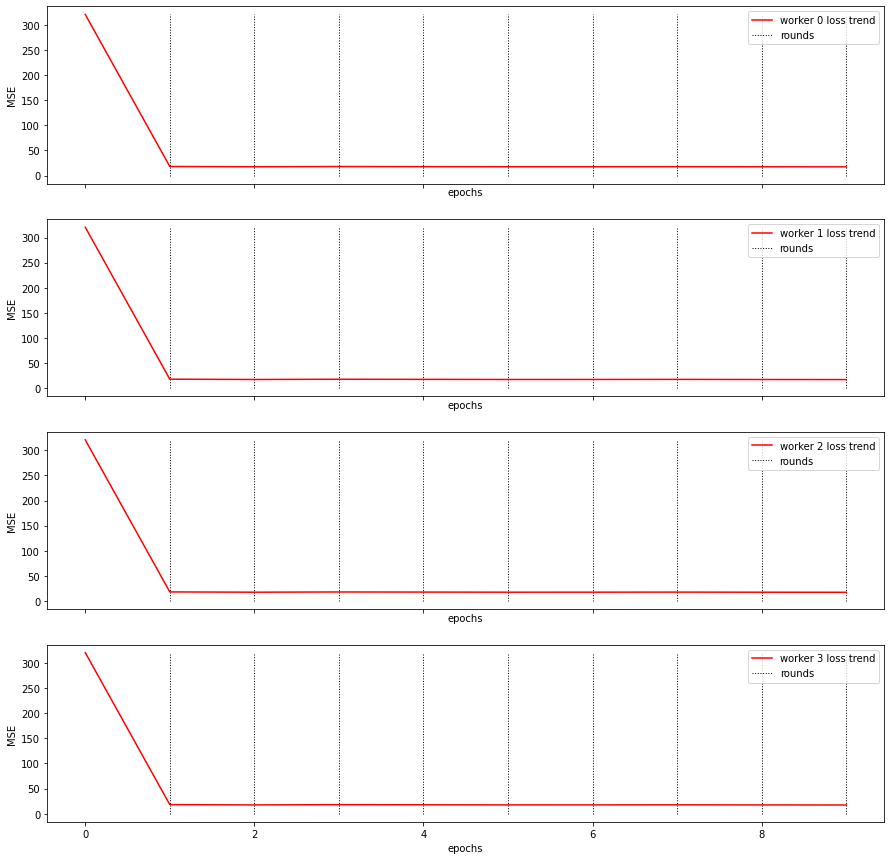

In [61]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds))[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend_linearRegression.pdf", bbox_inches='tight')

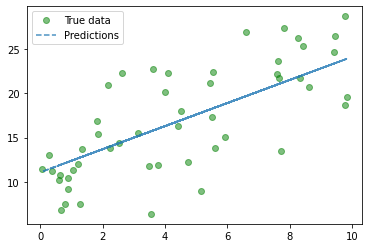

In [62]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

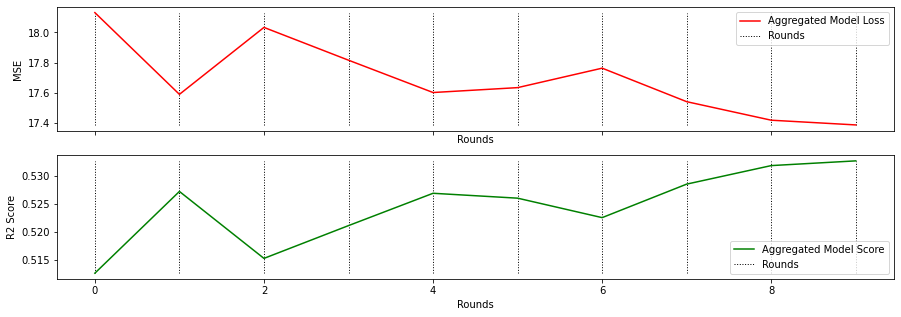

In [63]:
e = np.asarray(error)
a = np.asarray(score)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

axs[0].plot(e, label = "Aggregated Model Loss", color = 'red')
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("MSE")
axs[0].vlines((np.arange(num_rounds))[0:], ymin = np.min(e), ymax = np.max(e), linewidth=1, linestyle=':', label = 'Rounds')
axs[0].legend()

axs[1].plot(a, label = "Aggregated Model Score", color = 'green')
axs[1].set_xlabel("Rounds")
axs[1].set_ylabel("R2 Score")
axs[1].vlines((np.arange(num_rounds))[0:], ymin = np.min(a), ymax = np.max(a), linewidth=1, linestyle=':', label = 'Rounds')
axs[1].legend()

plt.savefig("Score_trend_LinearRegression.pdf", bbox_inches='tight')

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [64]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [86]:
import torch.nn.functional as F
import copy

class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 10):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x


In [87]:
w = []

for i in range(0, num_workers):
    
    w.append(customModel(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

In [88]:
w = []

w.append(customModel(dataset_X[0].size, dataset_y[0].size))

for i in range(1, num_workers):
    
    w.append(copy.deepcopy(w[0]))
    #w[i] = w[i].float()

In [89]:
learning_rate = 1e-3

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    optimizers.append(torch.optim.Adam(i.parameters(), lr=learning_rate))

In [90]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [91]:
from collections import defaultdict

local_epochs = 500

error = []
score = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        #print("# # # WORKER {} # # #\n".format(j))

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].step()
        
        #print("loss:\t{}".format(loss))    
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                #params[remote_index][param_index].set_(new_params[param_index])
                params[remote_index][param_index] = torch.nn.Parameter(new_params[param_index])
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    error.append(mean_squared_error(test_y, predicted))
    score.append(r2_score(test_y, predicted))
    


## ## ## ROUND 0 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 0.7764],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9337],
        [ 0.4421],
        [ 0.4359],
        [-0.8652],
        [ 0.9260],
        [ 0.9473]], requires_grad=True), Parameter containing:
tensor([ 0.9029, -0.8436, -0.3773, -0.6878,  0.9470, -0.4297, -0.4566,  0.5239,
        -0.4626, -0.4925], requires_grad=True), Parameter containing:
tensor([[-0.0277, -0.0304, -0.2463,  0.2636, -0.1395,  0.1122,  0.2750,  0.1595,
          0.0448,  0.2691]], requires_grad=True), Parameter containing:
tensor([0.0425], requires_grad=True)], [Parameter containing:
tensor([[ 0.7764],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9337],
        [ 0.4421],
        [ 0.4359],
        [-0.8652],
        [ 0.9260],
        [ 0.9473]], requires_grad=True), Parameter containing:
tensor([ 0.9029, -0.8436, -0.3773, -0.6878,  0.9470, -0.4297, -0.4566,  0.5239,
        -0.46

------ROUND 0------
Mean squared error: 320.691
Coefficient of determinaton: -7.620 


## ## ## ROUND 1 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor(

------ROUND 1------
Mean squared error: 297.502
Coefficient of determinaton: -6.996 


## ## ## ROUND 2 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor(

------ROUND 2------
Mean squared error: 46.513
Coefficient of determinaton: -0.250 


## ## ## ROUND 3 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([

------ROUND 3------
Mean squared error: 30.634
Coefficient of determinaton: 0.177 


## ## ## ROUND 4 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 4------
Mean squared error: 27.029
Coefficient of determinaton: 0.273 


## ## ## ROUND 5 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 5------
Mean squared error: 25.942
Coefficient of determinaton: 0.303 


## ## ## ROUND 6 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 6------
Mean squared error: 20.365
Coefficient of determinaton: 0.453 


## ## ## ROUND 7 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 7------
Mean squared error: 22.580
Coefficient of determinaton: 0.393 


## ## ## ROUND 8 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 8------
Mean squared error: 20.695
Coefficient of determinaton: 0.444 


## ## ## ROUND 9 ## ## ##

# # # WORKER 0 # # #

[[Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 1.4531, -0.8436, -0.3773, -0.6878,  1.0576,  0.0662, -0.0171,  0.8988,
         0.0664, -0.0714], requires_grad=True), Parameter containing:
tensor([[ 0.3146, -0.0304, -0.2463,  0.2636,  0.1561,  0.4665,  0.6225,  0.5315,
          0.3686,  0.5838]], requires_grad=True), Parameter containing:
tensor([0.3882], requires_grad=True)], [Parameter containing:
tensor([[ 1.2306],
        [-0.1497],
        [-0.8818],
        [-0.9036],
        [ 0.9624],
        [ 0.8421],
        [ 0.7885],
        [-0.4507],
        [ 1.3647],
        [ 1.2951]], requires_grad=True), Parameter containing:
tensor([ 

------ROUND 9------
Mean squared error: 18.350
Coefficient of determinaton: 0.507 



In [42]:
from collections import defaultdict

local_epochs = 1500

error = []
score = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        #print("# # # WORKER {} # # #\n".format(j))

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].step()
        
        #print("loss:\t{}".format(loss))    
        """
        predicted = w[j](Variable(torch.from_numpy(test_X).float())).data.numpy()
        
        print('Mean squared error: %.3f\n' 
              % mean_squared_error(test_y, predicted))
        print('Coefficient of determinaton: %.3f \n\n'
              % r2_score(test_y, predicted))
        error.append(mean_squared_error(test_y, predicted))
        score.append(r2_score(test_y, predicted))
        """
    
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    
    #tensor_params = torch.FloatTensor(params).float()
    #tensor_new_params = torch.FloatTensor(new_params).float()
    
    #for n in range(0, num_workers):
    #    print("## WORKER {}: weights norm".format(n))
    #    print(torch.norm(tensor_params[n]-tensor_new_params))
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                #params[remote_index][param_index].set_(new_params[param_index])
                params[remote_index][param_index] = torch.nn.Parameter(new_params[param_index])
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    error.append(mean_squared_error(test_y, predicted))
    score.append(r2_score(test_y, predicted))

KeyboardInterrupt: 

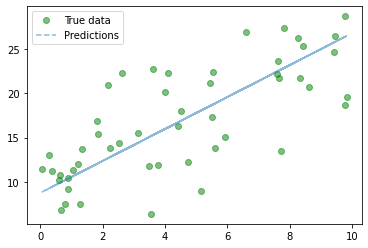

In [92]:
with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted,'--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [93]:
print(mean_squared_error(test_y, predicted))
print(r2_score(test_y, predicted))

18.35037782525214
0.5067710632444673


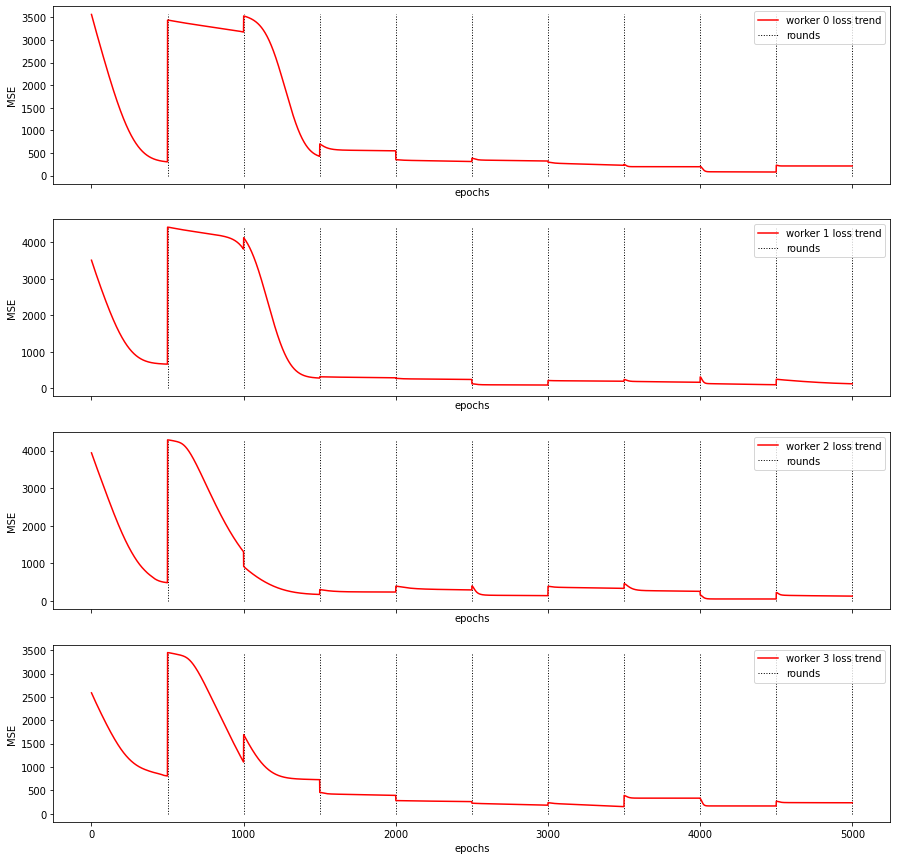

In [94]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds+1)*local_epochs)[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend.pdf", bbox_inches='tight')

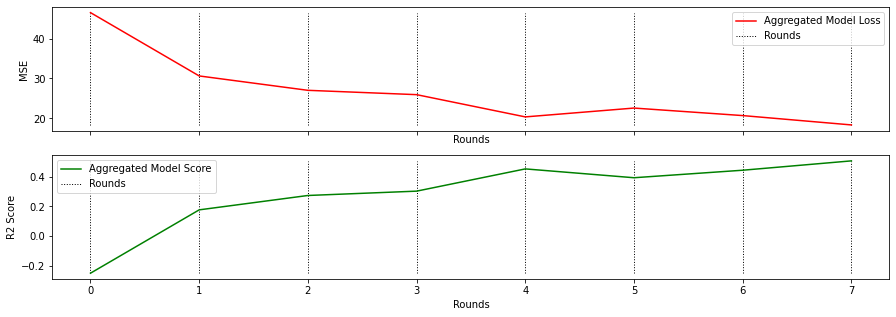

In [100]:
e = (np.asarray(error))[2:]
a = (np.asarray(score))[2:]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

axs[0].plot(e, label = "Aggregated Model Loss", color = 'red')
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("MSE")
axs[0].vlines((np.arange(num_rounds-2))[0:], ymin = np.min(e), ymax = np.max(e), linewidth=1, linestyle=':', label = 'Rounds')
axs[0].legend()

axs[1].plot(a, label = "Aggregated Model Score", color = 'green')
axs[1].set_xlabel("Rounds")
axs[1].set_ylabel("R2 Score")
axs[1].vlines((np.arange(num_rounds-2))[0:], ymin = np.min(a), ymax = np.max(a), linewidth=1, linestyle=':', label = 'Rounds')
axs[1].legend()

plt.savefig("Score_trend_LinearRegression.pdf", bbox_inches='tight')